In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import matplotlib.dates as mdates


In [2]:
doenças = pd.read_csv("../parsed-data/saude-series.csv")

In [3]:
população = pd.read_csv("../parsed-data/populacao.csv")


In [4]:
regioes = pd.read_csv("../data/geoloc/regioes-saude.csv", dtype={"REGIAO": "category","municipio": "str"})

In [5]:
IBGES_por_regiao = { x: regioes.query(f"REGIAO == '{x}'")["CODIBGE"].values for x in regioes.REGIAO.unique() }

In [6]:
regioes.set_index("CODIBGE", inplace=True)

In [7]:
população["região"] = população.COD_IBGE.apply(lambda x: regioes.loc[x,"REGIAO"])

In [8]:
população.set_index("COD_IBGE", inplace=True)

In [9]:
def get_pop(ibge, year):
    if year == 2022:
        year -= 1
    elif year == 2013:
        year += 1
    return população.loc[ibge,str(year)]

def get_pop_df(row):
    return get_pop(row["Ibge"],row["ano"])

In [10]:
doenças["população"] = doenças.apply(get_pop_df, axis=1)

In [11]:
população_das_regiões = população.groupby("região").sum()

In [12]:
doenças["região"] = doenças.Ibge.apply(lambda x: regioes.loc[x,"REGIAO"])

In [13]:
def pop_regiao(regiao, year):
    if year == 2022:
        year -= 1
    elif year == 2013:
        year += 1 
    return população_das_regiões.loc[regiao, str(year)]

In [14]:
def get_taxas(doença, regiao):
    subdf = doenças.drop(columns="Ibge").groupby(["região", "referencia"]).sum().loc[(regiao,),:].reset_index()
    pd.pivot_table(doenças[["referencia", "região", "Asma"]], index="referencia", columns="região", aggfunc=sum)[[("Asma","Carbonífera")]].plot()
    return subdf

Análise

In [15]:
from ipywidgets import Dropdown, Combobox

In [16]:
regi_select = Dropdown(options=regioes.REGIAO.unique(),description="Região")
regi_select

Dropdown(description='Região', options=('Meio Oeste', 'Xanxerê', 'Alto Vale do Itajaí', 'Oeste', 'Grande Flori…

In [17]:
doenca_select = Dropdown(options=doenças.columns[1:13], name="Doença", description="Doença")
doenca_select

Dropdown(description='Doença', options=('Asma', 'Diabetes', 'DPOC', 'Hipertensão arterial', 'Obesidade', 'Taba…

In [18]:
cidade_select.value.split("-")[1].strip().strip(")").strip("(")

NameError: name 'cidade_select' is not defined

In [19]:

rr = regi_select.value
dd = doenca_select.value
sss = pd.pivot_table(doenças[["referencia", "região", dd]], index="referencia", columns="região", aggfunc=sum)[(dd,rr)]

popr = [pop_regiao(rr,ano) for ano in (sss.index.values //100)]

<AxesSubplot:>

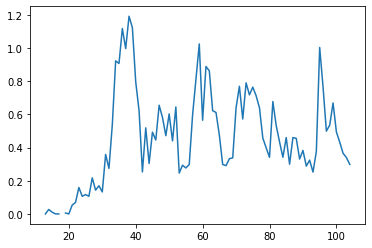

In [20]:
(sss/popr*1000).reset_index()[(dd,rr)].plot()

In [21]:
cidades_ = [x.municipio.title() + f" - ({i})" for (i,x) in regioes.iterrows()]
cidade_select = Combobox(
    placeholder='Escolha a cidade',
    options=cidades_,
    description='Cidade:',
    ensure_option=True,
    disabled=False
)
cidade_select

Combobox(value='', description='Cidade:', ensure_option=True, options=('Abdon Batista - (420005)', 'Abelardo L…

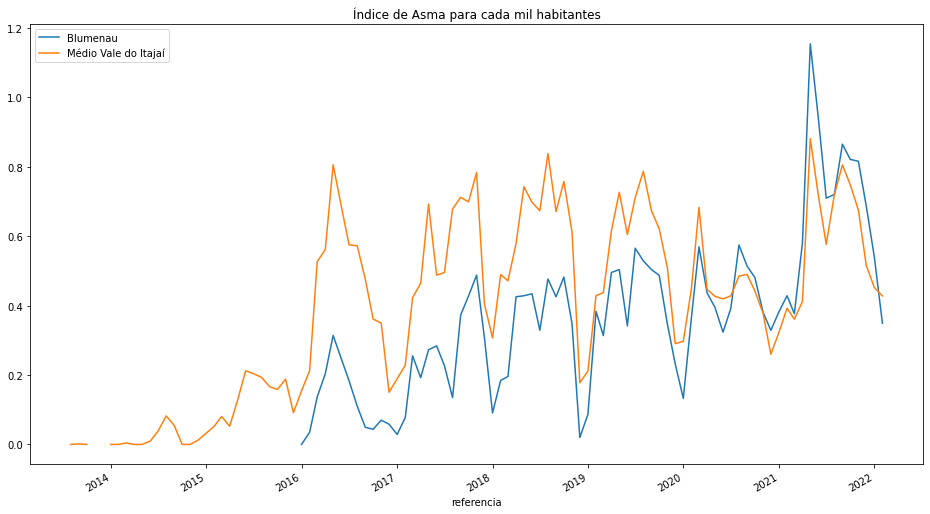

In [23]:
cdd = cidade_select.value
codibge = cidade_select.value.split("-")[1].strip().strip(")").strip("(")
rrr = regioes.loc[int(codibge),"REGIAO"]
dd = doenca_select.value
sss = pd.pivot_table(doenças[["referencia", "região", dd]], index="referencia", columns="região", aggfunc=sum)[(dd,rrr)]
popr = [pop_regiao(rrr,ano) for ano in (sss.index.values //100)]

nn = doenças.query(f"Ibge == {codibge}").set_index("referencia")[dd]
pp = doenças.query(f"Ibge == {codibge}").set_index("referencia")["população"]

fig, ax = plt.subplots(figsize=(16,9)) 
dadddos = pd.concat([nn/pp*1000, sss/popr*1000], axis=1 ).sort_index().reset_index()
datas = [ dt.strptime(str(x),"%Y%m") for x in dadddos["referencia"].values]
dadddos["referencia"] = datas
dadddos.set_index("referencia",inplace=True)
dadddos.columns = [cidade_select.value.split("-")[0], rrr]
dadddos.plot(ax=ax)
ax.set_title(f"Índice de {dd} para cada mil habitantes")
plt.show()

In [ ]:
mdf = pd.concat([nn/pp*1000, sss/popr*1000], axis=1 ).sort_index().reset_index()

In [65]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
output_notebook()



Loading BokehJS ...

In [69]:
TOOLTIPS = [ 
    ("data", "$x"),
    ("índice", "$y"),
]
source = ColumnDataSource(dadddos)

In [73]:

p = figure(title="Bossa",x_axis_type='datetime',tooltips=TOOLTIPS)
p.line(x="referencia", y=cidade_select.value.split("-")[0],source=source, line_color="red")
p.line(x="referencia", y=rrr, source=source)
show(p)

RuntimeError: Models must be owned by only a single document, LinearScale(id='2272', ...) is already in a doc

In [54]:
dadddos

,Blumenau,Médio Vale do Itajaí
referencia,,
2013-05-01,NaN,NaN
2013-07-01,NaN,NaN
2013-08-01,NaN,0.000000
2013-09-01,NaN,0.001367
2013-10-01,NaN,0.000000
...,...,...
2021-10-01,0.821466,0.748339
2021-11-01,0.816008,0.675211
2021-12-01,0.687739,0.516768


In [92]:
df_estadual = pd.pivot_table(doenças[["referencia", dd]], index="referencia",  aggfunc=sum)

6910553

In [85]:

def pop_estadoo(ano):
    if ano == 2022:
        ano -= 1
    elif ano == 2013:
        ano += 1 
    return população[str(ano)].sum()

In [93]:
pope =  [pop_estadoo(ano) for ano in (df_estadual.index.values //100)]


In [100]:
df_estadual["Asma"]/ pope

referencia
201305    0.000000
201307    0.000000
201308    0.000002
201309    0.000004
201310    0.000007
            ...   
202110    0.000689
202111    0.000699
202112    0.000531
202201    0.000484
202202    0.000405
Name: Asma, Length: 105, dtype: float64

In [101]:
df_estadual

,Asma
referencia,
201305,0
201307,0
201308,12
201309,26
201310,49
...,...
202110,5056
202111,5133
202112,3897
